In [1]:
import os
import tqdm
import time
from collections import defaultdict
from sklearn.metrics import cohen_kappa_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torch.optim as optim

import torchio as tio
import torchvision
from torchvision.models import resnet50

import optuna
from optuna.trial import TrialState

from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.dataset import proba_to_label, corn_label_from_logits

from losses import get_loss
from models import get_model
from datasets import CMRxMOTION2DEval

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

# The ensemble models
MODEL_TRAIN_DATE = "2022-08-24-17-02-17"         ### DATE OF THE TRAINING
MODEL_FILENAME = "0.7886.pth"                    ### MODEL FILENAME WHICH IS DEFINED BY THE VAL SPLIT CK SCORE
MODEL_TRAIN_DATE_2 = "2022-08-30-00-46-48"         ### DATE OF THE TRAINING
MODEL_FILENAME_2 = "0.7657.pth"                    ### MODEL FILENAME WHICH IS DEFINED BY THE VAL SPLIT CK SCORE
MODEL_TRAIN_DATE_3 = "2022-08-30-00-58-31"         ### DATE OF THE TRAINING
MODEL_FILENAME_3 = "0.7800.pth"
MODEL_TRAIN_DATE_4 = "2022-08-30-01-09-20"         ### DATE OF THE TRAINING
MODEL_FILENAME_4 = "0.7714.pth"                    ### MODEL FILENAME WHICH IS DEFINED BY THE VAL SPLIT CK SCORE
MODEL_TRAIN_DATE_5 = "2022-08-30-01-20-02"         ### DATE OF THE TRAINING
MODEL_FILENAME_5 = "0.7571.pth"

MODEL_NAME = "EfficientNet_B5"

MODE_3D_2D = '2D'                                ### 3D/2D CONFIG? WILL AFFECT DATALOADER AND NETWORK ARCHITECTURE
DATA_PATH = "path_in"                            ### TO BE RECONFIGURED
DEBUG = False                                    ### SWITCHING TO DEBUG MODE

DEVICE = torch.device("cuda")
BATCH_SIZE = 16
CLASSES = 3
DIR = os.getcwd()
# EPOCHS = 10
# TRAIN_VAL_RATIO = 0.8
# LOSS_NAME = "FocalLoss"
# ALPHA = 0.25
# GAMMA = 2.0
# LR = 0.0008
# OPTIMIZER_NAME = "RMSprop"
USE_CORAL = False
USE_CORN = True

if MODE_3D_2D == '2D':
    EPOCHS = 300


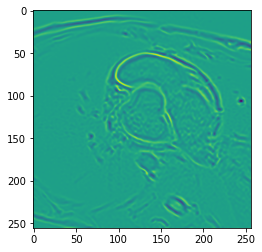

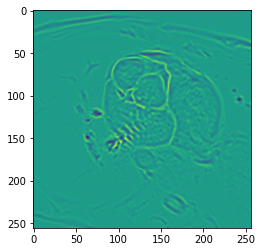

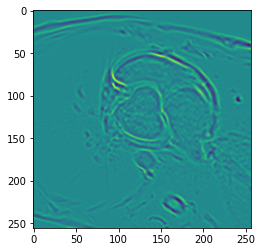

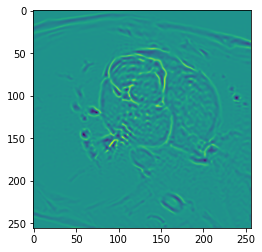

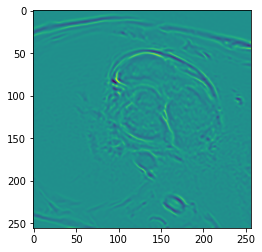

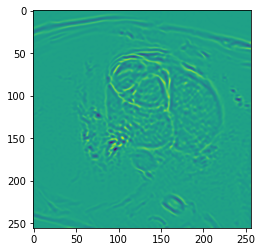

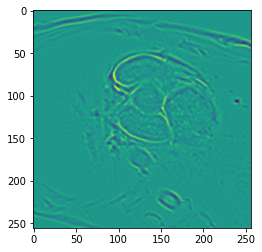

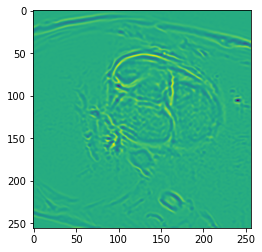

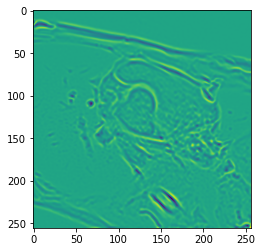

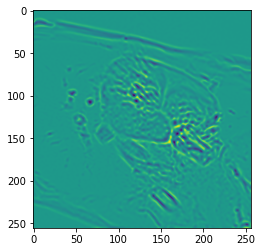

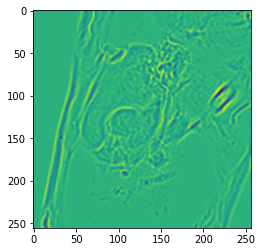

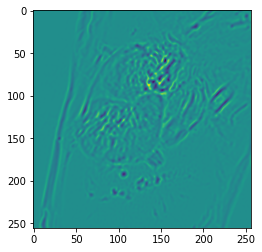

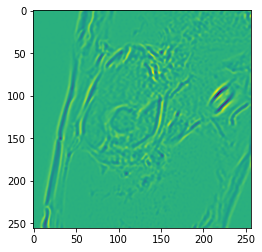

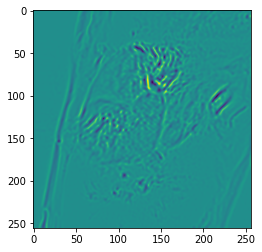

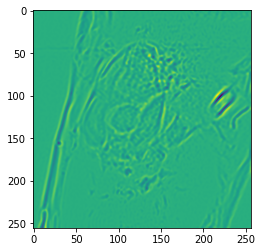

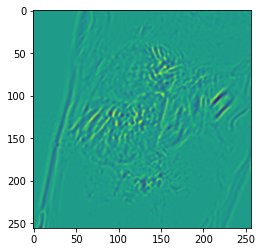

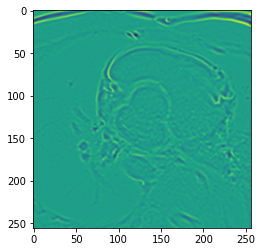

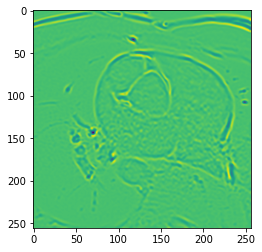

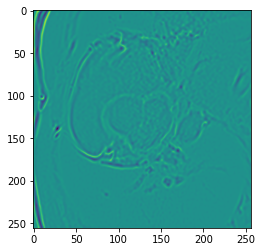

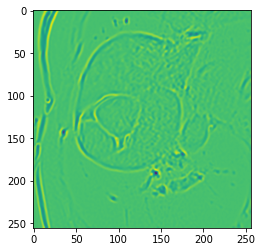

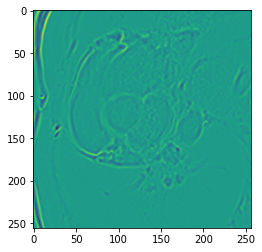

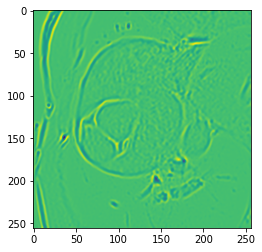

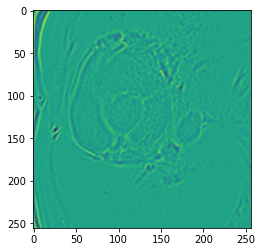

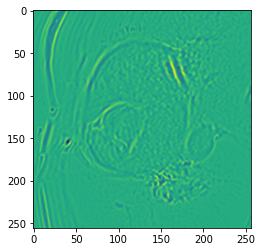

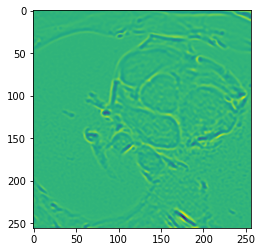

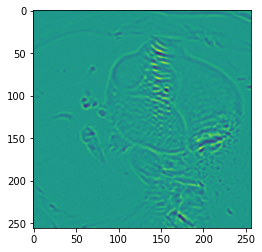

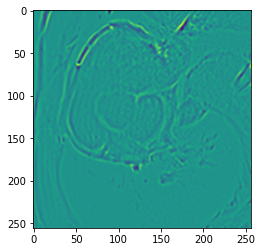

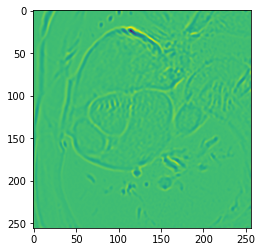

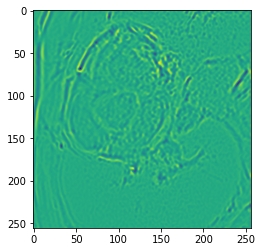

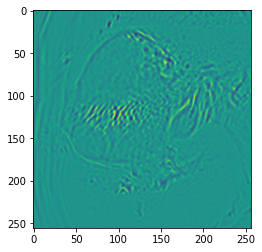

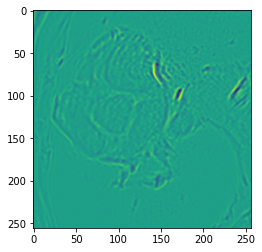

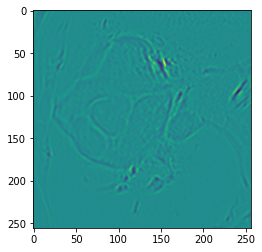

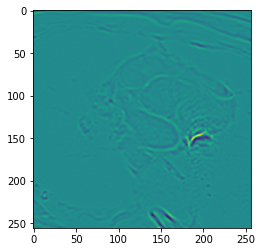

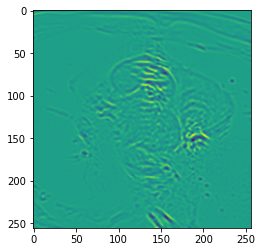

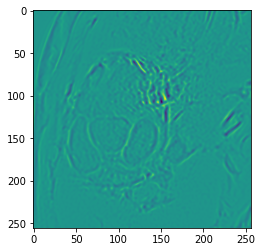

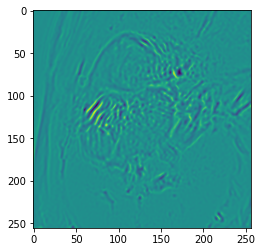

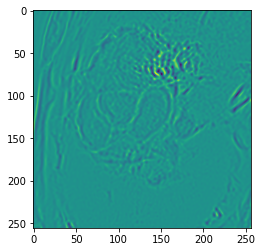

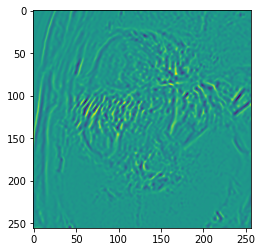

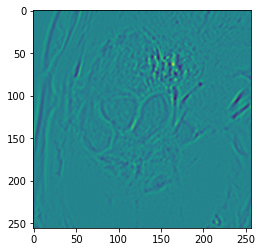

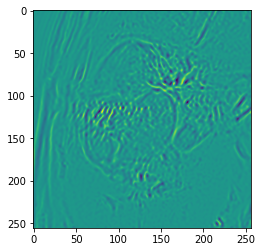

In [4]:
if MODE_3D_2D == "3D":
    pass
elif MODE_3D_2D == "2D":
    # TODO: Test-time Augmentation??
    # transforms_val_aug = T.Compose([
    #     T.RandomAffine(degrees=120, translate=(0.,0.1), scale=(0.85, 1.15)),
    #     T.CenterCrop(256),
    #     T.ToTensor(),
    #     T.ConvertImageDtype(torch.float),
    # ])
    transforms_val = T.Compose([
        T.CenterCrop(128),
        T.ToTensor(),
        T.ConvertImageDtype(torch.float),
    ])
    tio_transforms = [
        # tio.RandomMotion(degrees=3, translation=1, num_transforms=1),
        # tio.RescaleIntensity(out_min_max=(0, 1)),
        tio.RescaleIntensity(out_min_max=(0, 1), percentiles=(0.5, 99.5)),
    ]

    # TODO: Test-time Augmentation??
    # val_dataset_aug = CMRxMOTION2DEval(DATA_PATH, transforms=transforms_tr)
    val_dataset = CMRxMOTION2DEval(DATA_PATH,
                                   transforms=transforms_val,
                                   tio_transforms=tio_transforms)


In [5]:
# TODO: Test-time Augmentation??
# val_aug_loader = torch.utils.data.DataLoader(
#     val_dataset_aug,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=4
# )
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4
)

In [6]:
def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 16))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

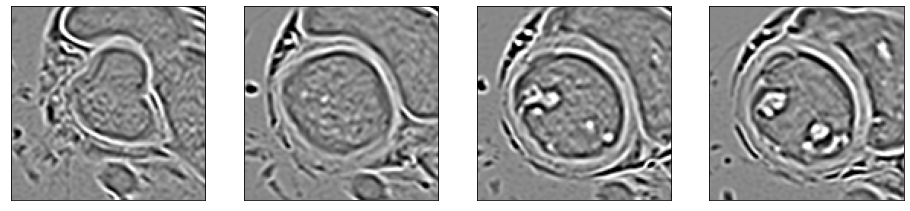

In [7]:
# Samples from the train and the val splits
show([(val_dataset.__getitem__(d))[0] for d in range(0, 4)])


In [8]:
def eval_loop(model, val_loader, use_corn=False, use_coral=False):
    model.eval()
    
    all_votes = defaultdict(lambda: [0, 0, 0])
    all_votes_bySlice = {}

    preds = defaultdict(lambda: -1)
    
    with torch.no_grad():
        for batch_idx, (data, pid, phase, depth, max_depth) in (enumerate(val_loader)):
            data = data.to(DEVICE)

            if USE_CORAL:
                _, probas = model(data)
            else:
                output = model(data)

            if USE_CORAL:
                pred = proba_to_label(probas).unsqueeze(dim=1)
            elif USE_CORN:
                pred = corn_label_from_logits(output).unsqueeze(dim=1)
            else:
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)

            # TODO: Max importance for mid, min importance
            # for apex and basal slices for final decision
            for i, (id, ph, d) in enumerate(zip(pid, phase, depth)):
                filename = "-".join([id, ph])
                # all_votes[filename][pred[i]] += torch.abs((max_depth[i] // 2 - d) / (max_depth[i] // 2))
                all_votes[filename][pred[i]] += 1

                if filename not in all_votes_bySlice:
                    all_votes_bySlice[filename] = {}
                all_votes_bySlice[filename][int(d)] = int(pred[i])

        for fn, vote in all_votes.items():
            final_pred = torch.argmax(torch.Tensor([vote]), dim=1)
            preds[fn] = final_pred.cpu().item() + 1
            if vote[2] > 0:
                preds[fn] = 3

        all_votes = sorted(all_votes.items())
        preds = sorted(preds.items())
        
        return all_votes, preds, all_votes_bySlice

In [9]:
from operator import add

# OPTIMIZE WITH THRESHOLD
def optimize_thresholds(votes):
    thres1 = 0.01
    max_acc = 0

    best_thres1 = 0
    best_thres2 = 1

    for i in range(100):
        acc = calculateAccuracy(get_pred_withThreshold(votes, thres1))

        print("THRES1: " + str(thres1) + ", ACC: " + str(acc))
        if acc > max_acc:
            max_acc = acc
            best_thres1 = thres1
        thres1 = thres1 + 0.01
    
    thres2 = 1

    for i in range(100):
        acc = calculateAccuracy(get_pred_withThreshold(votes, best_thres1, thres2))

        print("THRES1: " + str(thres2) + ", ACC: " + str(acc))
        if acc > max_acc:
            max_acc = acc
            best_thres2 = thres2
        thres2 = thres2 - 0.01

    print("ACCURACY: " + str(max_acc))
    print("THRES1: " + str(best_thres1))
    print("THRES2: " + str(best_thres2))

def get_pred_withThreshold(votes, thres1=0.1, thres2=2):

    pred = []
    for key in votes.keys():
        pred.append([key, 1 if votes[key][1] / (votes[key][0] + votes[key][1]) < thres1 else 2 if votes[key][1] / (votes[key][0] + votes[key][1]) < thres2 else 3])
    return pred

import csv
# OPTIMIZE WITH THRESHOLD AND GAUSSIAN BY SLICE
from matplotlib import pyplot as mp
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def optimize_thresholds_gaussian(votes):
    sigma = 0.1
    best_case = [0, 0, 0]
    max_gaussian_acc = 0

    for sigma in range(1000):
        sigma = sigma * 0.1 + 1

        # Optimize thresholds
        thres1 = 0.01
        max_acc = 0

        best_thres1 = 0
        best_thres2 = 1

        for i in range(100):
            acc = calculateAccuracy(get_pred_withThreshold_gaussian(votes, thres1, sigma = sigma))

            if acc > max_acc:
                max_acc = acc
                best_thres1 = thres1
            thres1 = thres1 + 0.01
        
        thres2 = 1

        for i in range(100):
            acc = calculateAccuracy(get_pred_withThreshold_gaussian(votes, best_thres1, thres2, sigma = sigma))

            if acc > max_acc:
                max_acc = acc
                best_thres2 = thres2
            thres2 = thres2 - 0.01

        if max_acc > max_gaussian_acc:
            max_gaussian_acc = max_acc
            best_case = [best_thres1, best_thres2, sigma]
            print("FOUND BETTER THRESHOLD! --------------------------------")
        print(max_acc)
        print([best_thres1, best_thres2, sigma])


    print("ACCURACY: " + str(max_acc))
    print("THRES1: " + str(best_thres1))
    print("THRES2: " + str(best_thres2))

def get_pred_withThreshold_gaussian(votes, thres1=0.1, thres2=2, sigma=0.1):

    pred = []
    for key in votes.keys():
        slice_results = votes[key]
        length = len(slice_results.keys())

        scores = [0, 0, 0]
        for slice in slice_results.keys():
            for i in slice_results[slice]:
                scores[i] = gaussian((slice - (length-1/2)), 0, sigma)  #sigma[slice-1] #
        full_score = sum(scores)
        pred.append([key, 1 if scores[1] / full_score < thres1 else 2 if scores[1] / full_score < thres2 else 3])
    return pred

import csv

def calculateAccuracy(pred):
    # load groundtruth
    path = os.path.join("csvFile")
    with open(path, mode='r') as infile:
        reader = csv.reader(infile)
        groundtruth = {rows[0]:rows[1] for rows in reader}

    patient_number = len(pred)
    correct_predictions = 0

    for i in range(patient_number):
        if pred[i][1] == int(groundtruth[pred[i][0]]):
            correct_predictions = correct_predictions +1
    return correct_predictions / patient_number

def appendAllVotes(av1, av2):
    av_all = av1
    for patient in av1.keys():
        for slice in av1[patient].keys():
            if type(av_all[patient][slice]) == int:
                av_all[patient][slice] = [av_all[patient][slice], av2[patient][slice]]
            else:
                av_all[patient][slice].append(av2[patient][slice])
    return av_all

def evaluate(val_loader):
    # Model Initializer
    model = get_model(MODEL_NAME, CLASSES, use_corn=USE_CORN, use_coral=USE_CORAL).to(DEVICE)
    model2 = get_model(MODEL_NAME, CLASSES, use_corn=USE_CORN, use_coral=USE_CORAL).to(DEVICE)
    model3 = get_model(MODEL_NAME, CLASSES, use_corn=USE_CORN, use_coral=USE_CORAL).to(DEVICE)

    model4 = get_model(MODEL_NAME, CLASSES, use_corn=USE_CORN, use_coral=USE_CORAL).to(DEVICE)
    model5 = get_model(MODEL_NAME, CLASSES, use_corn=USE_CORN, use_coral=USE_CORAL).to(DEVICE)
    
    model.load_state_dict(torch.load(os.path.join("saved", MODEL_TRAIN_DATE, MODEL_FILENAME)))
    model2.load_state_dict(torch.load(os.path.join("saved", MODEL_TRAIN_DATE_2, MODEL_FILENAME_2)))
    model3.load_state_dict(torch.load(os.path.join("saved", MODEL_TRAIN_DATE_3, MODEL_FILENAME_3)))
    model4.load_state_dict(torch.load(os.path.join("saved", MODEL_TRAIN_DATE_4, MODEL_FILENAME_4)))
    model5.load_state_dict(torch.load(os.path.join("saved", MODEL_TRAIN_DATE_5, MODEL_FILENAME_5)))

    # Evaluation of the model.
    all_votes, preds, all_votes_bySlice = eval_loop(model, val_loader, use_corn=USE_CORN, use_coral=USE_CORAL)
    all_votes2, preds2, all_votes_bySlice2 = eval_loop(model2, val_loader, use_corn=USE_CORN, use_coral=USE_CORAL)
    all_votes3, preds3, all_votes_bySlice3 = eval_loop(model3, val_loader, use_corn=USE_CORN, use_coral=USE_CORAL)
    all_votes4, preds4, all_votes_bySlice4 = eval_loop(model4, val_loader, use_corn=USE_CORN, use_coral=USE_CORAL)
    all_votes5, preds5, all_votes_bySlice5 = eval_loop(model5, val_loader, use_corn=USE_CORN, use_coral=USE_CORAL)

    all_votes_all = {all_votes3[i][0]: all_votes3[i][1] for i in range(len(all_votes3))}

    
    all_votes_all = {all_votes[i][0]: list(map(add, all_votes[i][1], map(add, all_votes2[i][1], map(add, all_votes3[i][1], map(add, all_votes4[i][1], all_votes5[i][1]))))) for i in range(len(all_votes))}
    
    print(all_votes_all)

    preds = get_pred_withThreshold(all_votes_all, thres1=0.5625, thres2=2) #0.58

    # Save the predictions of the model
    df = pd.DataFrame.from_dict(preds)
    df.columns = ["Image", "Label"]
    df.to_csv(os.path.join("saved", MODEL_TRAIN_DATE, "preds.csv"), index=False)

In [10]:
evaluate(val_loader)

{'P022-1-ED': [34, 21, 0], 'P022-1-ES': [50, 5, 0], 'P022-2-ED': [13, 42, 0], 'P022-2-ES': [33, 22, 0], 'P022-3-ED': [11, 44, 0], 'P022-3-ES': [21, 34, 0], 'P022-4-ED': [12, 43, 0], 'P022-4-ES': [14, 41, 0], 'P024-1-ED': [36, 19, 0], 'P024-1-ES': [45, 10, 0], 'P024-2-ED': [25, 30, 0], 'P024-2-ES': [31, 24, 0], 'P024-3-ED': [20, 35, 0], 'P024-3-ES': [23, 32, 0], 'P024-4-ED': [16, 39, 0], 'P024-4-ES': [8, 47, 0], 'P026-1-ED': [54, 6, 0], 'P026-1-ES': [59, 1, 0], 'P026-2-ED': [31, 29, 0], 'P026-2-ES': [38, 22, 0], 'P026-3-ED': [32, 28, 0], 'P026-3-ES': [47, 13, 0], 'P026-4-ED': [20, 40, 0], 'P026-4-ES': [25, 35, 0], 'P028-1-ED': [56, 4, 0], 'P028-1-ES': [60, 0, 0], 'P028-2-ED': [14, 46, 0], 'P028-2-ES': [30, 30, 0], 'P028-3-ED': [7, 53, 0], 'P028-3-ES': [22, 38, 0], 'P028-4-ED': [35, 25, 0], 'P028-4-ES': [44, 16, 0], 'P030-1-ED': [51, 9, 0], 'P030-1-ES': [55, 5, 0], 'P030-2-ED': [10, 50, 0], 'P030-2-ES': [13, 47, 0], 'P030-3-ED': [9, 51, 0], 'P030-3-ES': [9, 51, 0], 'P030-4-ED': [13, 47, 